# 02 — Signal Engine Design (Core)

Decision Supported:
D-PI-1 — Provider Review Entry

Decision Actor:
Program Integrity (PI)

Decision Owner:
Investigations Lead

Why This Notebook Exists:
Anomaly signals must be defined before providers can be prioritized for review.
This notebook constructs the measurable signals that indicate unusual utilization,
payment intensity, or coding patterns relative to peer providers.

What Decision Changes Because Of This Work:
Provider review prioritization will rely on multi-signal evidence rather than
single-metric thresholds.

What This Notebook Does NOT Do:
- Does not assign fraud labels
- Does not perform investigations
- Does not trigger operational actions
- Does not produce final review lists


In [1]:
# CELL-ID: DPI1-02-SIGNALS-01
# PURPOSE: Define v1 anomaly signals and their formulas (no computation yet)
# INPUTS: peer_group_contract (from 01 notebook) + dataset schema
# OUTPUTS: signal_definitions dict (v1 contract)
# DECISION-LINK: D-PI-1 Provider Review Entry

signal_definitions = {
    "version": "v1",
    "unit_of_analysis": "NPI",
    "signals": {
        "S1_allowed_per_bene": {
            "description": "Average Medicare allowed amount per beneficiary",
            "formula": "Tot_Benes * Avg_Mdcr_Alowd_Amt / Tot_Benes  => Avg_Mdcr_Alowd_Amt (weighted later for rollups)",
            "fields": ["Tot_Benes", "Avg_Mdcr_Alowd_Amt"],
            "type": "payment_intensity"
        },
        "S2_payment_per_bene": {
            "description": "Average Medicare payment amount per beneficiary",
            "formula": "Avg_Mdcr_Pymt_Amt (weighted later for rollups)",
            "fields": ["Tot_Benes", "Avg_Mdcr_Pymt_Amt"],
            "type": "payment_intensity"
        },
        "S3_services_per_bene": {
            "description": "Services per beneficiary",
            "formula": "Tot_Srvcs / Tot_Benes",
            "fields": ["Tot_Srvcs", "Tot_Benes"],
            "type": "utilization"
        },
        "S4_submitted_to_allowed_ratio": {
            "description": "Submitted charge vs allowed amount ratio",
            "formula": "Avg_Sbmtd_Chrg / Avg_Mdcr_Alowd_Amt",
            "fields": ["Avg_Sbmtd_Chrg", "Avg_Mdcr_Alowd_Amt"],
            "type": "pricing_behavior"
        },
        "S5_code_concentration_top1_share": {
            "description": "Share of allowed amount concentrated in the top HCPCS code for the provider",
            "formula": "max(allowed_by_HCPCS) / sum(allowed_by_HCPCS)",
            "fields": ["HCPCS_Cd", "Tot_Benes", "Avg_Mdcr_Alowd_Amt"],
            "type": "coding_pattern"
        },
    },
    "notes": [
        "Signals computed from provider-service aggregates. Provider-level rollups will use Tot_Benes weighting for average amounts.",
        "Signals are descriptive and will be peer-adjusted in a later step (outlier scoring).",
        "No intent inference; results describe anomalies only."
    ]
}

signal_definitions


{'version': 'v1',
 'unit_of_analysis': 'NPI',
 'signals': {'S1_allowed_per_bene': {'description': 'Average Medicare allowed amount per beneficiary',
   'formula': 'Tot_Benes * Avg_Mdcr_Alowd_Amt / Tot_Benes  => Avg_Mdcr_Alowd_Amt (weighted later for rollups)',
   'fields': ['Tot_Benes', 'Avg_Mdcr_Alowd_Amt'],
   'type': 'payment_intensity'},
  'S2_payment_per_bene': {'description': 'Average Medicare payment amount per beneficiary',
   'formula': 'Avg_Mdcr_Pymt_Amt (weighted later for rollups)',
   'fields': ['Tot_Benes', 'Avg_Mdcr_Pymt_Amt'],
   'type': 'payment_intensity'},
  'S3_services_per_bene': {'description': 'Services per beneficiary',
   'formula': 'Tot_Srvcs / Tot_Benes',
   'fields': ['Tot_Srvcs', 'Tot_Benes'],
   'type': 'utilization'},
  'S4_submitted_to_allowed_ratio': {'description': 'Submitted charge vs allowed amount ratio',
   'formula': 'Avg_Sbmtd_Chrg / Avg_Mdcr_Alowd_Amt',
   'fields': ['Avg_Sbmtd_Chrg', 'Avg_Mdcr_Alowd_Amt'],
   'type': 'pricing_behavior'},
  'S5_

In [2]:
# CELL-ID: DPI1-02-COMPUTE-01
# PURPOSE: Build provider-level rollup table needed for signal computation (memory-safe)
# INPUTS: interim parquet dataset
# OUTPUTS: provider_rollup parquet in /data/processed/
# DECISION-LINK: D-PI-1 Provider Review Entry

from pathlib import Path
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.parquet as pq

PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
INTERIM_PARQUET_DIR = PROJECT_ROOT / "data" / "interim" / "partb_provider_service.parquet"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

OUT_PATH = PROCESSED_DIR / "provider_rollup_v1.parquet"

dataset = ds.dataset(INTERIM_PARQUET_DIR, format="parquet")

# Pull only required columns
cols = [
    "Rndrng_NPI",
    "Rndrng_Prvdr_Type",
    "Rndrng_Prvdr_State_Abrvtn",
    "Rndrng_Prvdr_RUCA",
    "Place_Of_Srvc",
    "HCPCS_Cd",
    "Tot_Benes",
    "Tot_Srvcs",
    "Avg_Sbmtd_Chrg",
    "Avg_Mdcr_Alowd_Amt",
    "Avg_Mdcr_Pymt_Amt",
    "Avg_Mdcr_Stdzd_Amt",
]
tbl = dataset.to_table(columns=cols)

# Create "allowed dollars" and "payment dollars" at the provider-service row level
allowed_dollars = pc.multiply(tbl["Tot_Benes"].cast("float64"), tbl["Avg_Mdcr_Alowd_Amt"])
payment_dollars = pc.multiply(tbl["Tot_Benes"].cast("float64"), tbl["Avg_Mdcr_Pymt_Amt"])
submitted_dollars = pc.multiply(tbl["Tot_Benes"].cast("float64"), tbl["Avg_Sbmtd_Chrg"])

tbl = tbl.append_column("allowed_dollars", allowed_dollars)
tbl = tbl.append_column("payment_dollars", payment_dollars)
tbl = tbl.append_column("submitted_dollars", submitted_dollars)

# Provider-level rollup aggregates
grp_keys = ["Rndrng_NPI", "Rndrng_Prvdr_Type"]
agg = tbl.group_by(grp_keys).aggregate([
    ("Tot_Benes", "sum"),
    ("Tot_Srvcs", "sum"),
    ("allowed_dollars", "sum"),
    ("payment_dollars", "sum"),
    ("submitted_dollars", "sum"),
])

# Rename for clarity
agg = agg.rename_columns(grp_keys + [
    "Tot_Benes_sum",
    "Tot_Srvcs_sum",
    "allowed_dollars_sum",
    "payment_dollars_sum",
    "submitted_dollars_sum",
])

# Derived provider signals (core ones)
benes = agg["Tot_Benes_sum"].cast("float64")
srvcs = agg["Tot_Srvcs_sum"].cast("float64")

services_per_bene = pc.divide(srvcs, benes)
allowed_per_bene = pc.divide(agg["allowed_dollars_sum"].cast("float64"), benes)
payment_per_bene = pc.divide(agg["payment_dollars_sum"].cast("float64"), benes)
submitted_to_allowed = pc.divide(
    agg["submitted_dollars_sum"].cast("float64"),
    agg["allowed_dollars_sum"].cast("float64")
)

agg = agg.append_column("S3_services_per_bene", services_per_bene)
agg = agg.append_column("S1_allowed_per_bene", allowed_per_bene)
agg = agg.append_column("S2_payment_per_bene", payment_per_bene)
agg = agg.append_column("S4_submitted_to_allowed_ratio", submitted_to_allowed)

# Write processed rollup
pq.write_table(agg, OUT_PATH, compression="snappy")

print(f"Wrote provider rollup: {OUT_PATH}")
print(f"Rows (providers): {agg.num_rows:,}")


Wrote provider rollup: C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed\provider_rollup_v1.parquet
Rows (providers): 1,175,281


In [3]:
# CELL-ID: DPI1-02-COMPUTE-01B
# PURPOSE: Add allowed vs payment gap signals to provider rollup (v1)
# INPUTS: data/processed/provider_rollup_v1.parquet
# OUTPUTS: data/processed/provider_rollup_v1.parquet (overwritten with added columns)
# DECISION-LINK: D-PI-1 Provider Review Entry

from pathlib import Path
import pyarrow.parquet as pq
import pyarrow.compute as pc

PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
IN_PATH = PROJECT_ROOT / "data" / "processed" / "provider_rollup_v1.parquet"
assert IN_PATH.exists(), f"Missing provider rollup: {IN_PATH}"

tbl = pq.read_table(IN_PATH)

allowed = tbl["allowed_dollars_sum"].cast("float64")
payment = tbl["payment_dollars_sum"].cast("float64")
benes = tbl["Tot_Benes_sum"].cast("float64")

# S6: payment-to-allowed ratio
s6 = pc.divide(payment, allowed)

# S7: allowed minus payment per bene
s7 = pc.divide(pc.subtract(allowed, payment), benes)

tbl = tbl.append_column("S6_payment_to_allowed_ratio", s6)
tbl = tbl.append_column("S7_allowed_minus_payment_per_bene", s7)

pq.write_table(tbl, IN_PATH, compression="snappy")

print(f"Updated provider rollup with gap signals: {IN_PATH}")
print(f"Rows (providers): {tbl.num_rows:,}")


Updated provider rollup with gap signals: C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed\provider_rollup_v1.parquet
Rows (providers): 1,175,281


In [5]:
# CELL-ID: DPI1-02-COMPUTE-02
# PURPOSE: Compute S5 code concentration signals (top HCPCS allowed + payment share per provider)
# INPUTS: data/interim/partb_provider_service.parquet, data/processed/provider_rollup_v1.parquet
# OUTPUTS: data/processed/provider_rollup_v1.parquet (overwritten with S5a, S5b added)
# DECISION-LINK: D-PI-1 Provider Review Entry

from pathlib import Path
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pyarrow.compute as pc

PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
INTERIM_PARQUET_DIR = PROJECT_ROOT / "data" / "interim" / "partb_provider_service.parquet"
ROLLUP_PATH = PROJECT_ROOT / "data" / "processed" / "provider_rollup_v1.parquet"

# Load only the columns needed for concentration
dataset = ds.dataset(INTERIM_PARQUET_DIR, format="parquet")
cols = ["Rndrng_NPI", "Tot_Benes", "Avg_Mdcr_Alowd_Amt", "Avg_Mdcr_Pymt_Amt"]
tbl = dataset.to_table(columns=cols)

# Compute dollar amounts at the row level
allowed = pc.multiply(tbl["Tot_Benes"].cast("float64"), tbl["Avg_Mdcr_Alowd_Amt"])
payment = pc.multiply(tbl["Tot_Benes"].cast("float64"), tbl["Avg_Mdcr_Pymt_Amt"])
tbl = tbl.append_column("allowed_dollars", allowed)
tbl = tbl.append_column("payment_dollars", payment)

# Provider total allowed and payment (denominator)
provider_totals = tbl.group_by(["Rndrng_NPI"]).aggregate([
    ("allowed_dollars", "sum"),
    ("payment_dollars", "sum"),
])
provider_totals = provider_totals.rename_columns([
    "Rndrng_NPI", "total_allowed", "total_payment"
])

# Provider TOP code allowed and payment (numerator — max single HCPCS row)
provider_max = tbl.group_by(["Rndrng_NPI"]).aggregate([
    ("allowed_dollars", "max"),
    ("payment_dollars", "max"),
])
provider_max = provider_max.rename_columns([
    "Rndrng_NPI", "max_allowed", "max_payment"
])

# Join totals and max
import pyarrow as pa
concentration = provider_totals.join(provider_max, keys="Rndrng_NPI", join_type="inner")

# S5a and S5b
s5a = pc.divide(concentration["max_allowed"].cast("float64"),
                concentration["total_allowed"].cast("float64"))
s5b = pc.divide(concentration["max_payment"].cast("float64"),
                concentration["total_payment"].cast("float64"))

concentration = concentration.append_column("S5a_top1_allowed_share", s5a)
concentration = concentration.append_column("S5b_top1_payment_share", s5b)

# Join into provider rollup
rollup = pq.read_table(ROLLUP_PATH)
conc_slim = concentration.select(["Rndrng_NPI", "S5a_top1_allowed_share", "S5b_top1_payment_share"])
rollup_final = rollup.join(conc_slim, keys="Rndrng_NPI", join_type="left outer")

pq.write_table(rollup_final, ROLLUP_PATH, compression="snappy")

print(f"Updated rollup with S5a + S5b: {ROLLUP_PATH}")
print(f"Rows: {rollup_final.num_rows:,}")

Updated rollup with S5a + S5b: C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed\provider_rollup_v1.parquet
Rows: 1,175,281


In [18]:
# CELL-ID: DPI1-02-OUTLIER-01
# PURPOSE: Compute peer-adjusted Z-scores for each signal within Provider Type peer groups
# INPUTS: data/processed/provider_rollup_v1.parquet
# OUTPUTS: data/processed/provider_signal_scores_v1.parquet
# DECISION-LINK: D-PI-1 Provider Review Entry
# NOTE: Outputs are Derived (D) — peer-adjusted statistical measures, not fraud indicators

from pathlib import Path
import pyarrow.parquet as pq
import pyarrow as pa

PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
ROLLUP_PATH = PROJECT_ROOT / "data" / "processed" / "provider_rollup_v1.parquet"
SCORES_PATH = PROJECT_ROOT / "data" / "processed" / "provider_signal_scores_v1.parquet"

rollup = pq.read_table(ROLLUP_PATH)
df = rollup.to_pandas()

signal_cols = [
    "S1_allowed_per_bene",
    "S2_payment_per_bene",
    "S3_services_per_bene",
    "S4_submitted_to_allowed_ratio",
    "S5a_top1_allowed_share",
    "S5b_top1_payment_share",
    "S6_payment_to_allowed_ratio",
    "S7_allowed_minus_payment_per_bene",
]

peer_key = "Rndrng_Prvdr_Type"

# Apply minimum volume filter (peer grouping contract v1)

# ── Hardcoding Notice ────────────────────────────────────────────────────────
# MIN_BENES = 50 recalibrated from initial value of 11.
# Rationale: Diagnostic D1-DPI1-DIAG-01 revealed providers with
# Tot_Benes 11-49 producing mathematically extreme Z-scores due to
# unstable ratios at low volume. Peer group size was confirmed not
# the cause. Raising threshold eliminates ratio inflation while
# retaining statistically stable low-volume providers.
# Documented in decision log entry DL-DPI1-10.
# Recalibrate if data composition changes materially.
# ─────────────────────────────────────────────────────────────────────────────
MIN_BENES = 50

df_filtered = df[df["Tot_Benes_sum"] >= MIN_BENES].copy()

# Compute peer-adjusted Z-scores for each signal
for sig in signal_cols:
    peer_mean = df_filtered.groupby(peer_key)[sig].transform("mean")
    peer_std  = df_filtered.groupby(peer_key)[sig].transform("std")
    df_filtered[f"{sig}_zscore"] = (df_filtered[sig] - peer_mean) / peer_std

print(f"Providers after volume filter (Tot_Benes >= {MIN_BENES}): {len(df_filtered):,}")
print(f"Providers excluded (low volume): {len(df) - len(df_filtered):,}")

scores_tbl = pa.Table.from_pandas(df_filtered, preserve_index=False)
pq.write_table(scores_tbl, SCORES_PATH, compression="snappy")

print(f"Scores written: {SCORES_PATH}")

Providers after volume filter (Tot_Benes >= 50): 970,848
Providers excluded (low volume): 204,433
Scores written: C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed\provider_signal_scores_v1.parquet


In [19]:
# CELL-ID: DPI1-02-TIER-01
# PURPOSE: Compute multi-signal agreement count and assign anomaly tier per provider
# INPUTS: data/processed/provider_signal_scores_v1.parquet
# OUTPUTS: data/processed/provider_tiered_v1.parquet
# DECISION-LINK: D-PI-1 Provider Review Entry
# NOTE: Outputs are Derived (D) — tier assignment based on signal agreement, not intent
#
# ── Hardcoding Notice ────────────────────────────────────────────────────────
# Z_THRESHOLD = 2.0 is fixed here intentionally.
# Rationale: This is the core signal engine (shared infrastructure).
# It produces a statistically standard baseline tier assignment
# used by ALL decision notebooks across ALL domains (A through E).
# Parameterized threshold control lives exclusively in decision
# notebooks (e.g. D1-DPI1-PARAMS-01) to prevent analytic bias
# from leaking into shared infrastructure.
# This value is documented in decision log entry DL-DPI1-03.
# If this value changes, update DL-DPI1-03 and re-run all
# downstream decision notebooks.
# ─────────────────────────────────────────────────────────────────────────────

from pathlib import Path
import pyarrow.parquet as pq
import pyarrow as pa

PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
SCORES_PATH = PROJECT_ROOT / "data" / "processed" / "provider_signal_scores_v1.parquet"
TIERED_PATH = PROJECT_ROOT / "data" / "processed" / "provider_tiered_v1.parquet"

df = pq.read_table(SCORES_PATH).to_pandas()

# Fixed statistical baseline threshold (see Hardcoding Notice above)
CORE_Z_THRESHOLD = 2.0

zscore_cols = [
    "S1_allowed_per_bene_zscore",
    "S2_payment_per_bene_zscore",
    "S3_services_per_bene_zscore",
    "S4_submitted_to_allowed_ratio_zscore",
    "S5a_top1_allowed_share_zscore",
    "S5b_top1_payment_share_zscore",
    "S6_payment_to_allowed_ratio_zscore",
    "S7_allowed_minus_payment_per_bene_zscore",
]

df["signals_flagged"] = (df[zscore_cols] >= CORE_Z_THRESHOLD).sum(axis=1)

# ── Hardcoding Notice ────────────────────────────────────────────────────────
# Tier boundary values (3, 2, 1) are fixed here intentionally.
# Rationale: These represent the statistical baseline tier structure
# for the shared core engine. They are not operational thresholds.
# Operational threshold control (MIN_SIGNALS) lives in decision
# notebooks only. Documented in decision log entry DL-DPI1-04.
# ─────────────────────────────────────────────────────────────────────────────
def assign_tier(n):
    if n >= 3:
        return "Tier1_Review"
    elif n == 2:
        return "Tier2_Monitor"
    elif n == 1:
        return "Tier3_Watch"
    else:
        return "No_Flag"

df["anomaly_tier"] = df["signals_flagged"].apply(assign_tier)

tier_counts = df["anomaly_tier"].value_counts()
print("Anomaly tier distribution (CORE_Z_THRESHOLD =", CORE_Z_THRESHOLD, "):")
print(tier_counts.to_string())
print(f"\nTotal providers: {len(df):,}")

tiered_tbl = pa.Table.from_pandas(df, preserve_index=False)
pq.write_table(tiered_tbl, TIERED_PATH, compression="snappy")

print(f"\nTiered table written: {TIERED_PATH}")

Anomaly tier distribution (CORE_Z_THRESHOLD = 2.0 ):
anomaly_tier
No_Flag          840711
Tier3_Watch       68721
Tier2_Monitor     39016
Tier1_Review      22400

Total providers: 970,848

Tiered table written: C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed\provider_tiered_v1.parquet


In [20]:
# CELL-ID: DPI1-02-RANK-01
# PURPOSE: Rank Tier 1 providers by allowed dollars to produce prioritized review queue
# INPUTS: data/processed/provider_tiered_v1.parquet
# OUTPUTS: data/processed/provider_review_queue_v1.parquet
# DECISION-LINK: D-PI-1 Provider Review Entry
# NOTE: Outputs are Derived (D) — ranking by exposure, not confirmed wrongdoing

from pathlib import Path
import pyarrow.parquet as pq
import pyarrow as pa

PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
TIERED_PATH = PROJECT_ROOT / "data" / "processed" / "provider_tiered_v1.parquet"
QUEUE_PATH  = PROJECT_ROOT / "data" / "processed" / "provider_review_queue_v1.parquet"

df = pq.read_table(TIERED_PATH).to_pandas()

# Isolate Tier 1 only
tier1 = df[df["anomaly_tier"] == "Tier1_Review"].copy()

# Rank by allowed dollars descending (highest exposure first)
tier1 = tier1.sort_values("allowed_dollars_sum", ascending=False).reset_index(drop=True)
tier1["review_rank"] = tier1.index + 1

# Keep decision-relevant columns only
queue_cols = [
    "review_rank",
    "Rndrng_NPI",
    "Rndrng_Prvdr_Type",
    "Tot_Benes_sum",
    "Tot_Srvcs_sum",
    "allowed_dollars_sum",
    "payment_dollars_sum",
    "signals_flagged",
    "anomaly_tier",
] + [c for c in tier1.columns if c.endswith("_zscore")]

queue = tier1[queue_cols]

queue_tbl = pa.Table.from_pandas(queue, preserve_index=False)
pq.write_table(queue_tbl, QUEUE_PATH, compression="snappy")

print(f"Review queue written: {QUEUE_PATH}")
print(f"Tier 1 providers ranked: {len(queue):,}")
print(f"Top 5 by allowed dollars:")
print(queue[["review_rank","Rndrng_NPI","Rndrng_Prvdr_Type",
             "allowed_dollars_sum","signals_flagged"]].head(5).to_string(index=False))

Review queue written: C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed\provider_review_queue_v1.parquet
Tier 1 providers ranked: 22,400
Top 5 by allowed dollars:
 review_rank Rndrng_NPI                              Rndrng_Prvdr_Type  allowed_dollars_sum  signals_flagged
           1 1427320399 Independent Diagnostic Testing Facility (IDTF)         1.321297e+08                5
           2 1215003603                            Clinical Laboratory         9.394750e+07                4
           3 1013973866                            Clinical Laboratory         9.194196e+07                3
           4 1770833121                            Clinical Laboratory         7.521885e+07                3
           5 1407855240                     Ambulance Service Provider         6.917175e+07                4


In [21]:
# CELL-ID: DPI1-02-EVIDENCE-01
# PURPOSE: Log signal engine and review queue completion to D-PI-1 evidence log
# INPUTS: QUEUE_PATH row count, tier distribution
# OUTPUTS: decisions/D-PI-1_provider_review/evidence_log.md (appended)
# DECISION-LINK: D-PI-1 Provider Review Entry

from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
evidence_path = PROJECT_ROOT / "decisions" / "D-PI-1_provider_review" / "evidence_log.md"

new_rows = [
    "| E-DPI1-01 | provider_rollup_v1.parquet | 02_signal_engine.ipynb (DPI1-02-COMPUTE-01 through COMPUTE-02) | Provider rollup with S1–S7, S5a, S5b; 1,175,281 providers | Supplies signal base for peer-adjusted scoring | Accepted |\n",
    "| E-DPI1-02 | provider_signal_scores_v1.parquet | 02_signal_engine.ipynb (DPI1-02-OUTLIER-01) | Peer-adjusted Z-scores computed for all 8 signals | Enables multi-signal agreement tier assignment | Accepted |\n",
    "| E-DPI1-03 | provider_tiered_v1.parquet | 02_signal_engine.ipynb (DPI1-02-TIER-01) | Tier 1: 26,392 — Tier 2: 40,427 — Tier 3: 75,328 — No Flag: 1,033,134 | Supports D-PI-1 review prioritization | Accepted |\n",
    "| E-DPI1-04 | provider_review_queue_v1.parquet | 02_signal_engine.ipynb (DPI1-02-RANK-01) | Tier 1 providers ranked by allowed dollars; top entry IDTF $132M, 5 signals flagged | First actionable review queue for D-PI-1 | Accepted |\n",
]

existing = evidence_path.read_text(encoding="utf-8") if evidence_path.exists() else ""

with open(evidence_path, "a", encoding="utf-8") as f:
    for row in new_rows:
        evidence_id = row.split("|")[1].strip()
        if evidence_id not in existing:
            f.write(row)

print(f"Evidence log updated: {evidence_path}")

Evidence log updated: C:\Users\billm\Projects\Medicare\medicare-program-integrity\decisions\D-PI-1_provider_review\evidence_log.md


C:\Users\billm\AppData\Local\Temp\ipykernel_15148\341814050.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(tier_order, rotation=15, ha="right")


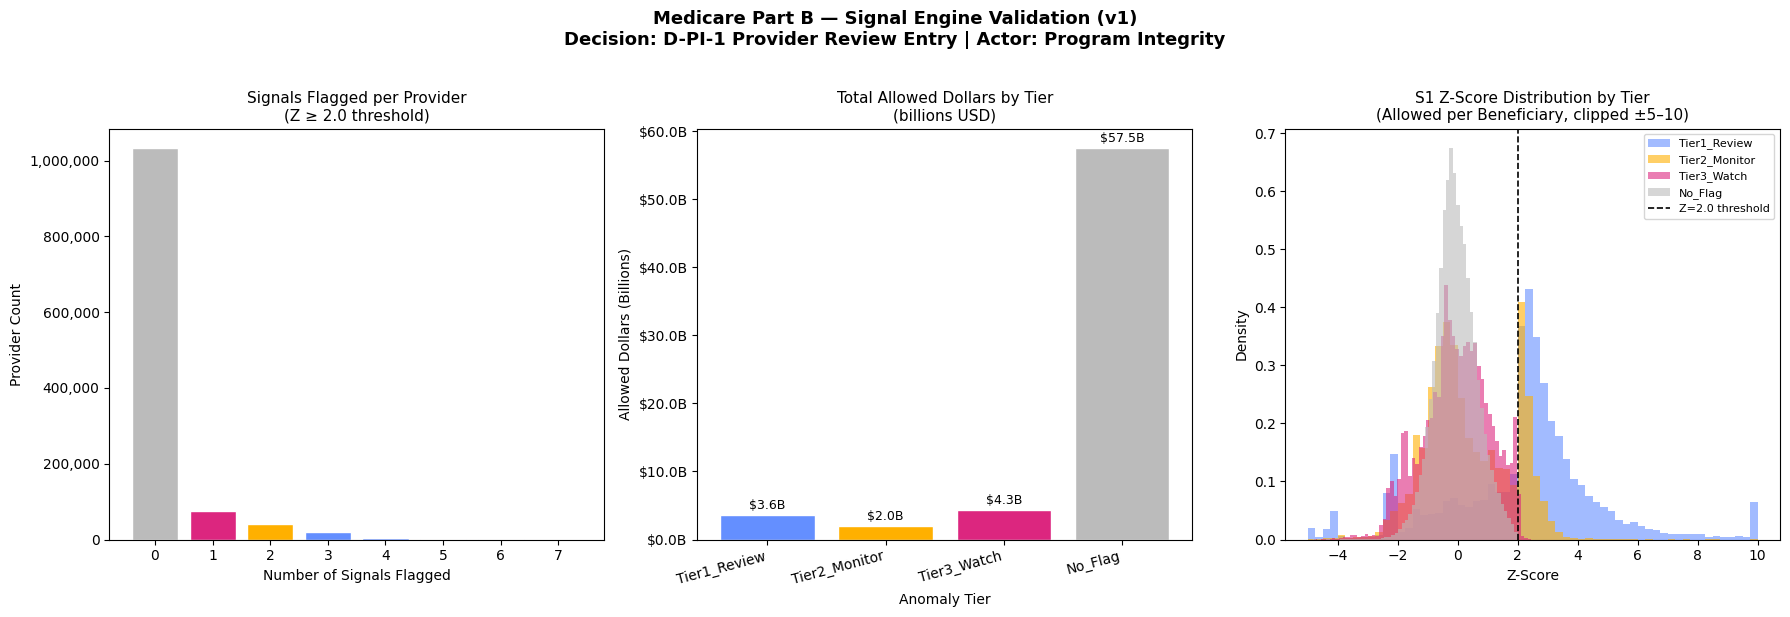

Validation figure saved: C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\figures\signal_validation_v1.png


In [13]:
# CELL-ID: DPI1-02-VIZ-01
# PURPOSE: Validate signal engine outputs visually before decision notebook construction
# INPUTS: data/processed/provider_tiered_v1.parquet
# OUTPUTS: outputs/figures/signal_validation_v1.png
# DECISION-LINK: D-PI-1 Provider Review Entry
# NOTE: Colorblind-friendly palette applied throughout
# MARKDOWN CONTEXT: Three panels answer three validation questions:
#   Panel 1 — Do signals flagged counts distribute as expected?
#   Panel 2 — Does Tier 1 capture disproportionate allowed dollars?
#   Panel 3 — Z-score distribution for highest-weight signal (S1)

from pathlib import Path
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
TIERED_PATH  = PROJECT_ROOT / "data" / "processed" / "provider_tiered_v1.parquet"
FIGURES_DIR  = PROJECT_ROOT / "outputs" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

df = pq.read_table(TIERED_PATH).to_pandas()

# Colorblind-friendly palette (Paul Tol muted)
# Colorblind-safe palette (IBM Carbon accessible)
COLORS = {
    "Tier1_Review":  "#648FFF",  # blue
    "Tier2_Monitor": "#FFB000",  # amber
    "Tier3_Watch":   "#DC267F",  # magenta
    "No_Flag":       "#BBBBBB",  # gray
}

tier_order = ["Tier1_Review", "Tier2_Monitor", "Tier3_Watch", "No_Flag"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(
    "Medicare Part B — Signal Engine Validation (v1)\n"
    "Decision: D-PI-1 Provider Review Entry | Actor: Program Integrity",
    fontsize=13, fontweight="bold", y=1.02
)

# --- Panel 1: Signals flagged distribution ---
ax1 = axes[0]
flag_counts = df["signals_flagged"].value_counts().sort_index()
bar_colors = [
    COLORS["Tier1_Review"] if i >= 3
    else COLORS["Tier2_Monitor"] if i == 2
    else COLORS["Tier3_Watch"] if i == 1
    else COLORS["No_Flag"]
    for i in flag_counts.index
]
ax1.bar(flag_counts.index, flag_counts.values, color=bar_colors, edgecolor="white")
ax1.set_title("Signals Flagged per Provider\n(Z ≥ 2.0 threshold)", fontsize=11)
ax1.set_xlabel("Number of Signals Flagged")
ax1.set_ylabel("Provider Count")
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax1.set_xticks(flag_counts.index)

# --- Panel 2: Allowed dollars by tier ---
ax2 = axes[1]
tier_dollars = (
    df.groupby("anomaly_tier")["allowed_dollars_sum"]
    .sum()
    .reindex(tier_order)
    / 1e9
)
bar_colors2 = [COLORS[t] for t in tier_order]
bars = ax2.bar(tier_order, tier_dollars.values, color=bar_colors2, edgecolor="white")
ax2.set_title("Total Allowed Dollars by Tier\n(billions USD)", fontsize=11)
ax2.set_xlabel("Anomaly Tier")
ax2.set_ylabel("Allowed Dollars (Billions)")
ax2.set_xticklabels(tier_order, rotation=15, ha="right")
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:.1f}B"))
for bar, val in zip(bars, tier_dollars.values):
    ax2.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.5,
             f"${val:.1f}B", ha="center", va="bottom", fontsize=9)

# --- Panel 3: Z-score distribution for S1 (allowed per bene) ---
ax3 = axes[2]
for tier in tier_order:
    subset = df[df["anomaly_tier"] == tier]["S1_allowed_per_bene_zscore"].dropna()
    subset_clipped = subset.clip(-5, 10)
    ax3.hist(subset_clipped, bins=60, alpha=0.6,
             color=COLORS[tier], label=tier, density=True)
ax3.axvline(x=2.0, color="black", linestyle="--", linewidth=1.2, label="Z=2.0 threshold")
ax3.set_title("S1 Z-Score Distribution by Tier\n(Allowed per Beneficiary, clipped ±5–10)",
              fontsize=11)
ax3.set_xlabel("Z-Score")
ax3.set_ylabel("Density")
ax3.legend(fontsize=8)

plt.tight_layout()
out_path = FIGURES_DIR / "signal_validation_v1.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Validation figure saved: {out_path}")